In [14]:
import pandas as pd
import numpy as np

In [8]:
df = pd.read_csv('lab3_pose.csv')

TypeError: read_csv() got an unexpected keyword argument 'index'

In [6]:
df.reset_index(drop=True, inplace=True)


In [7]:
df

,idx,p_x,p_y,p_z,q_w,q_x,q_y,q_z
0,0,-1.52195,1.36339,0.094305,0.743646,-1.715190e-06,0.015906,-0.668384
1,1,-1.52195,1.36341,0.094366,0.743626,2.949370e-07,0.016090,-0.668402
2,2,-1.52196,1.36341,0.094335,0.743639,2.211670e-05,0.015974,-0.668391
3,3,-1.52195,1.36342,0.094355,0.743634,-8.520680e-06,0.016101,-0.668393
4,4,-1.52196,1.36339,0.094348,0.743627,9.688590e-06,0.016069,-0.668401
...,...,...,...,...,...,...,...,...
2887,2887,-1.98537,1.16358,0.094133,0.499459,-1.274180e-02,-0.005692,0.866225
2888,2888,-1.98538,1.16359,0.094181,0.499421,-1.278310e-02,-0.005774,0.866246
2889,2889,-1.98543,1.16353,0.094264,0.499454,-1.286200e-02,-0.005721,0.866226
2890,2890,-1.98538,1.16358,0.094166,0.499393,-1.268970e-02,-0.005787,0.866263


In [11]:
df.iloc[:,1]

0      -1.52195
1      -1.52195
2      -1.52196
3      -1.52195
4      -1.52196
         ...   
2887   -1.98537
2888   -1.98538
2889   -1.98543
2890   -1.98538
2891   -1.98539
Name: p_x, Length: 2892, dtype: float64

In [15]:
b2v = np.identity(4)
b2v

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [17]:
x = df.iloc[:,1]
b2v[0, 3] = x[0]
b2v

array([[ 1.     ,  0.     ,  0.     , -1.52195],
       [ 0.     ,  1.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  1.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  1.     ]])

In [18]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# Transform from body to camera frame
b2c = np.array([[0, -1, 0, 0],
                [-1, 0, 0, 0],
                [0, 0, -1, 0],
                [0, 0, 0, 1]])

# Transform from camera to body frame
c2b = np.linalg.inv(b2c)

# camera intrinsic matrix 
K = np.array([[698.86, 0, 306.91],
                    [0, 699.13, 150.34],
                    [0, 0, 1.0]])

K_inv = np.linalg.inv(K)

df = pd.read_csv('lab3_pose.csv')

x = df.iloc[:,1]
y = df.iloc[:,2]
z = df.iloc[:,3]

qw = df.iloc[:,4]
qx = df.iloc[:,5]
qy = df.iloc[:,6]
qz = df.iloc[:,7]

co_ord = []

def find_circle(ImgStr) :

    image = cv2.imread(ImgStr, cv2.IMREAD_COLOR)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur_image = cv2.GaussianBlur(gray_image, (15, 5), 0)
    contours, _ = cv2.findContours(blur_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    roi = image[y:y+h, x:x+w]
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    roi_blur = cv2.GaussianBlur(roi_gray, (5, 5), 0)
    circles = cv2.HoughCircles(roi_blur, cv2.HOUGH_GRADIENT, dp=1, minDist=50, param1=200, param2=30, minRadius=10, maxRadius=20)
    Out = []
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x_circle, y_circle, r) in circles:
            Out.append([x_circle, y_circle])
    return Out


for i in range(len(x)):
    b2v = np.identity(4)
    b2v[0, 3] = x[i]
    b2v[1, 3] = y[i]
    b2v[2, 3] = z[i]

    quaternion = np.array([qx[i], qy[i], qz[i], qw[i]])

    r_matrix = R.from_quat(quaternion)
    r_matrix = r_matrix.as_matrix()
    b2v[0:3, 0:3] = r_matrix[0:3, 0:3]

    pixel = find_circle('output_folder/image_'+ str(i)+'.jpg')

    for j in range(len(pixel)):

        pixel_coord = np.array([pixel[j][0], pixel[j][1], 1]).reshape(-1, 1)  # xs, ys
        normal_proj = np.dot(K_inv, pixel_coord)  # xn, yn
        xn = normal_proj[0][0]
        yn = normal_proj[1][0]

        c2v = b2v.dot(c2b) # T_vc
        
        p_cam = np.array([xn*z[i], yn*z[i], z[i], 1]) # location of camera frame
        p_vic = np.dot(c2v, p_cam) # transform from camera frame to vicon frame

        coord = p_vic[:2] # 2D coordinates
        co_ord.append(coord)

print(co_ord)

[array([-1.03902298, -0.72176535]), array([-1.0409695 , -0.71495129]), array([-1.04437615, -0.71155796]), array([-1.04001927, -0.70876946]), array([-1.03751144, -0.71073808]), array([-1.03970204, -0.71038488]), array([-1.04429826, -0.7100251 ]), array([-1.04472982, -0.71762792]), array([-1.04146287, -0.71402766]), array([-1.03655628, -0.71158893]), array([-1.03422361, -0.71256825]), array([-1.03710966, -0.70706201]), array([-1.04018396, -0.71028137]), array([-1.0381893 , -0.70816306]), array([-1.03113621, -0.71440553]), array([-1.03189464, -0.71278815]), array([-1.02892172, -0.70942251]), array([-1.03153015, -0.70578018]), array([-1.02837627, -0.70391434]), array([-1.03513078, -0.70106617]), array([-1.035602  , -0.70083232]), array([-1.03933891, -0.70304252]), array([-1.03546248, -0.70932821]), array([-1.03562941, -0.71718998]), array([-1.03774765, -0.70848271]), array([-1.03637408, -0.70529069]), array([-1.03919223, -0.70869803]), array([-1.03988859, -0.70500357]), array([-1.0378207 ,

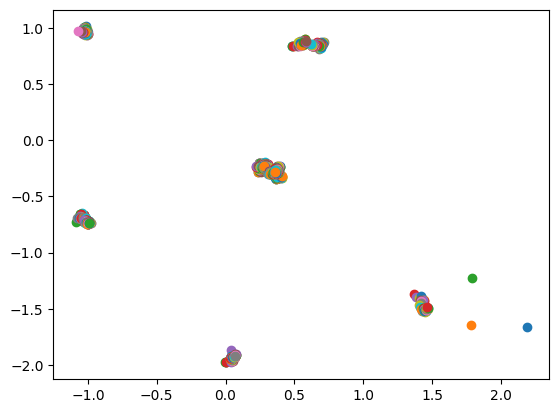

In [22]:
import matplotlib.pyplot as plt

for i in range(len(co_ord)):
    plt.scatter(co_ord[i][0], co_ord[i][1])


/home/ash/anaconda3/envs/aer1217-project/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


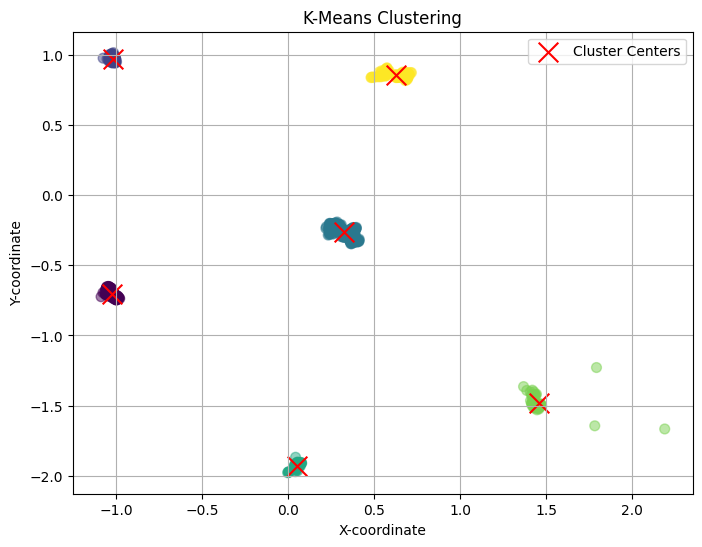

In [26]:
from sklearn.cluster import KMeans

data = np.array(co_ord)
# Number of clusters
k = 6

# Initialize KMeans object
kmeans = KMeans(n_clusters=k)

# Fit KMeans clustering model to the data
kmeans.fit(data)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

# Plotting the clusters
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=50, alpha=0.5)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200, label='Cluster Centers')
plt.title('K-Means Clustering')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
cluster_centers

array([[-1.02569094, -0.70419584],
       [-1.02048641,  0.97182007],
       [ 0.32514307, -0.26521881],
       [ 0.05090503, -1.92765716],
       [ 1.45788953, -1.47944645],
       [ 0.62955919,  0.85643858]])